In [92]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# helper functions

def rss(w0, w1, xs, ys):
    return 0.5 * np.sum((ys - (w0 + w1*xs))**2)

def plot_objective_3d(xs, ys, w0_space, w1_space, ws=None):
    w0s, w1s = np.meshgrid(w0_space, w1_space)
    Z = np.array([rss(w0, w1, xs, ys) for w0, w1 in zip(np.ravel(w0s), np.ravel(w1s))])
    Z = Z.reshape(w1s.shape)

    fig = plt.figure(figsize=[8,6])
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(w0s, w1s, Z, cmap='viridis', alpha=0.8)

    if ws is not None:
        ws = np.array(ws).squeeze()
        zs = np.array([rss(ws[i,0], ws[i,1], xs, ys) for i in range(len(ws))])
        ax.plot(ws[:,0], ws[:,1], zs, marker='o', color='red')

    ax.set_xlabel('w0')
    ax.set_ylabel('w1')
    ax.set_zlabel('RSS')
    ax.set_title('RSS Objective Function E(w)')
    plt.tight_layout()
    plt.show()
    plt.close()

def plot_contours(xs, ys, w0_space, w1_space, ws=None):
    w0s, w1s = np.meshgrid(w0_space, w1_space)
    Z = np.array([rss(w0, w1, xs, ys) for w0, w1 in zip(np.ravel(w0s), np.ravel(w1s))])
    Z = Z.reshape(w1s.shape)

    plt.contour(w0_space, w1_space, Z, levels=50, cmap='viridis')
    if ws is not None:
        ws = np.array(ws).squeeze()
        plt.plot(ws[:,0], ws[:,1], marker='o', color='red')
    plt.xlabel('w0')
    plt.ylabel('w1')
    plt.title('RSS Contours')
    plt.show()
    plt.close()

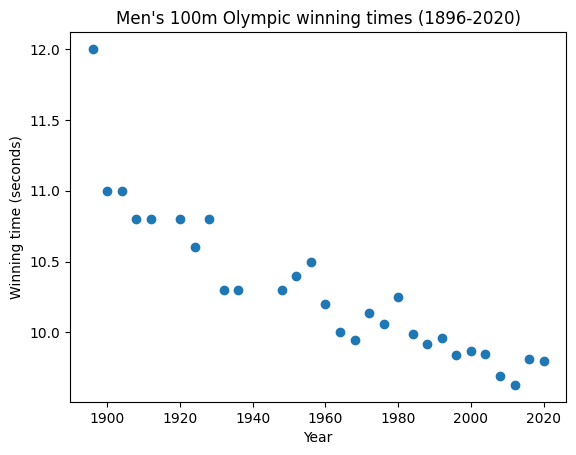

In [94]:
xs = np.array([1896,1900,1904,1908,1912,1920,1924,1928,1932,1936,1948,1952,1956,1960,1964,1968,1972,1976,1980,1984,1988,1992,1996,2000,2004,2008,2012,2016,2020])
ys = np.array([12,11,11,10.80,10.80,10.80,10.60,10.80,10.30,10.30,10.30,10.40,10.50,10.20,10,9.95,10.14,10.06,10.25,9.99,9.92,9.96,9.84,9.87,9.85,9.69,9.63,9.81,9.80])

# reshape both to column vector for consistency with course notes
xs = xs.reshape(-1, 1)
ys = ys.reshape(-1, 1)

fig, ax = plt.subplots()
ax.scatter(xs, ys)
ax.set_xlabel('Year')
ax.set_ylabel('Winning time (seconds)')
ax.set_title('Men\'s 100m Olympic winning times (1896-2020)')
plt.show()

In [ ]:
# Ordinary Least Squares solution (normal equations)
X_b = np.hstack([np.ones_like(xs), xs]) # add bias term: design matrix
w_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ ys # normal equations
print(w_best)


[[ 3.42532169e+01]
 [-1.22200523e-02]]


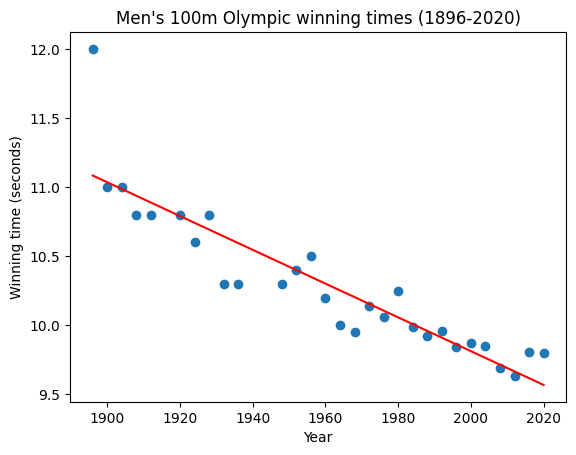

In [ ]:
# Plot solution from normal equations:
# w0 is intercept, w1 is slope
fig, ax = plt.subplots()
ax.scatter(xs, ys)
ax.plot(xs, w_best[0] + w_best[1]*xs, color='red')
ax.set_xlabel('Year')
ax.set_ylabel('Winning time (seconds)')
ax.set_title('Men\'s 100m Olympic winning times (1896-2020)')
plt.show()

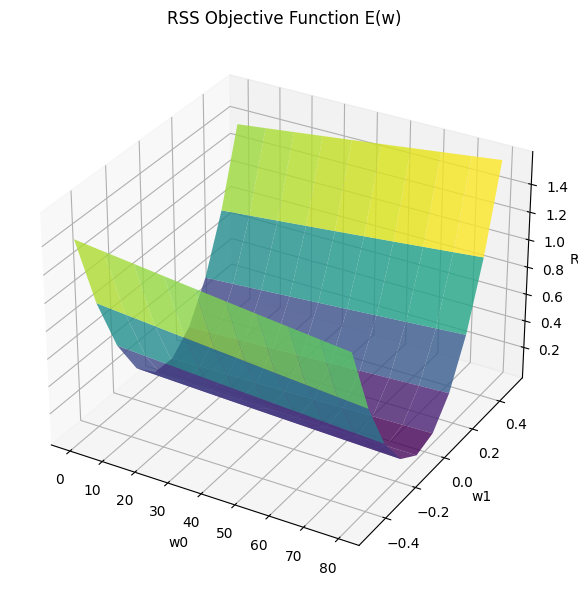

In [ ]:
# Show the shape of the objective function for possible values of w0 and w1
w0_space = np.linspace(0, 80, 10)
w1_space = np.linspace(-0.5, 0.5, 10)

plot_objective_3d(xs, ys, w0_space, w1_space)

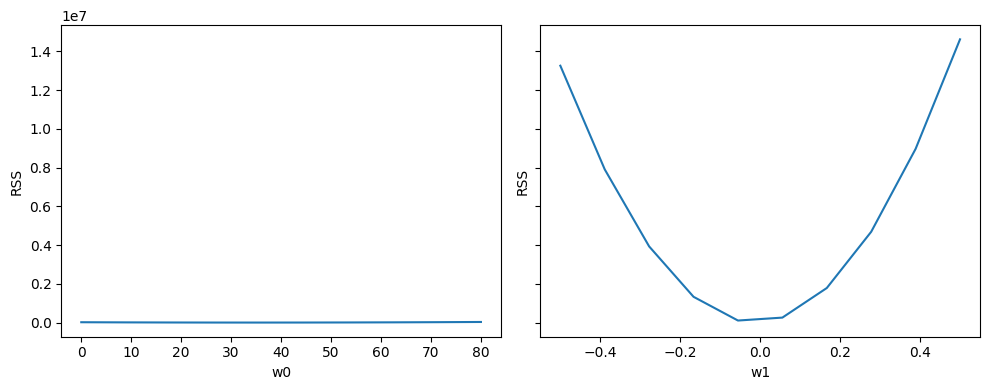

In [ ]:
# Show each axis individually with shared axis - we can see that w1 (slope) is more sensitive
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[10,4], sharey=True)
ax1.plot(w0_space, [rss(w0, w_best[1], xs, ys) for w0 in w0_space])
ax1.set_xlabel('w0')
ax1.set_ylabel('RSS')
ax2.plot(w1_space, [rss(w_best[0], w1, xs, ys) for w1 in w1_space])
ax2.set_xlabel('w1')
ax2.set_ylabel('RSS')  
plt.tight_layout()
plt.show()


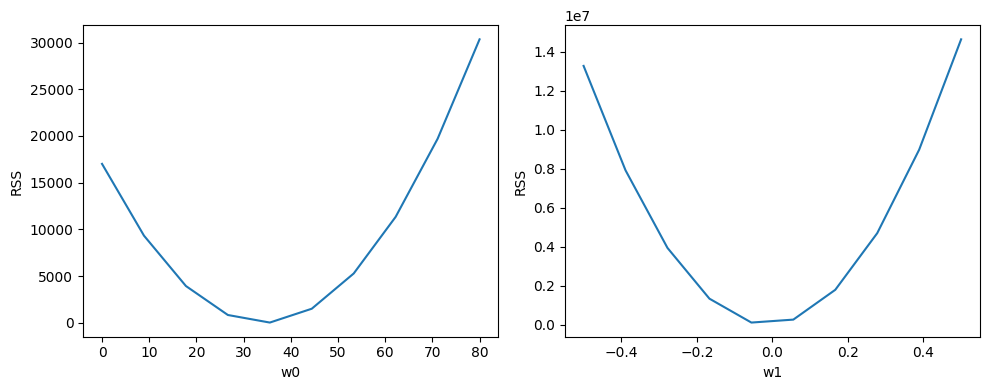

In [ ]:
# Show each axis individually without shared axis - both are convex
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[10,4])
ax1.plot(w0_space, [rss(w0, w_best[1], xs, ys) for w0 in w0_space])
ax1.set_xlabel('w0')
ax1.set_ylabel('RSS')
ax2.plot(w1_space, [rss(w_best[0], w1, xs, ys) for w1 in w1_space])
ax2.set_xlabel('w1')
ax2.set_ylabel('RSS')  
plt.tight_layout()
plt.show()

In [ ]:
# Gradient descent solution for minimizing RSS

n_iters = 200 # maximum number of iterations
eta = 2e-2 # learning rate
rng = np.random.default_rng()
w_gd = rng.normal(size=2).reshape(-1, 1) # random weight initialization, column vector
print(f"Initial guess for w: {w_gd.squeeze()}.T")

# remember we need to normalize the features for gradient descent to work well
# here we can just use the years since 1896 scaled to [0,1]
xd = (xs - xs.min())/(xs.max()-xs.min())
yd = ys.copy() # no need to normalize target variable
X_d = np.hstack([np.ones_like(xd), xd]) # design matrix with normalized features

losses = []
ws = [w_gd.copy()] # save initial weights

for i in range(n_iters):
    y_pred = X_d @ w_gd
    error = y_pred - yd
    loss = 0.5 * np.sum(error**2)
    
    losses.append(loss) # save loss at each iteration
    ws.append(w_gd.copy()) # save weights at each iteration

    grad = X_d.T @ error # gradient computation: equivalent to X.T @ (X @ w - y)
    w_gd = w_gd - eta * grad # gradient descent step: next weights

    # print(w_gd.squeeze(), loss)

    if np.abs(grad).sum() < 1e-3:
        print(f"Converged after {i} iterations.")
        break

# append final weights and loss
ws.append(w_gd.copy())
losses.append(loss)
print(f"Final solution for w: {w_gd.squeeze()}.T")

w_star = np.linalg.inv(X_d.T @ X_d) @ X_d.T @ yd # normal equations
print(f"Normal equations (analytical) solution for w: {w_star.squeeze()}.T")



Initial guess for w: [ 0.23520368 -2.06261057].T
Final solution for w: [11.08350198 -1.51440203].T
Normal equations (analytical) solution for w: [11.08399786 -1.51528648].T


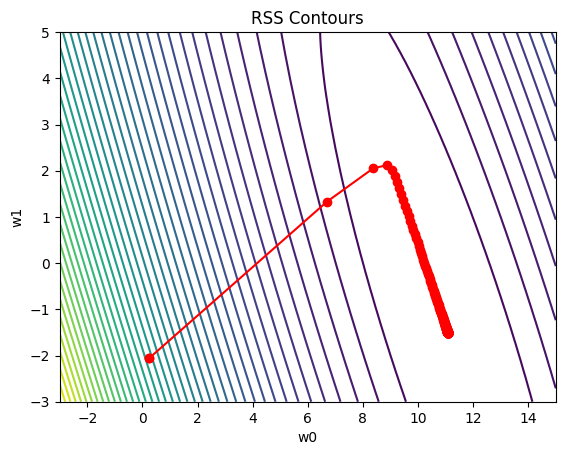

In [ ]:
# Plot contours of the loss function and the path taken by gradient descent
# Weights at each iteration are shown in red
ws = np.array(ws).squeeze()
w0_space_scaled = np.linspace(-3, 15, 100)
w1_space_scaled = np.linspace(-3, 5, 100)

plot_contours(xd, yd, w0_space=w0_space_scaled, w1_space=w1_space_scaled, ws=ws)

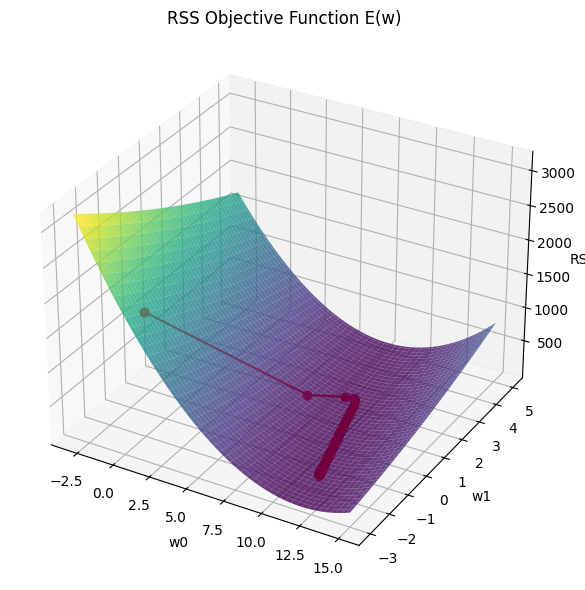

In [ ]:
# Show the gradient descent path on the 3D objective function
# this will look different to above since we've scaled the features (independent variable x) for gradient descent
plot_objective_3d(xd, yd, w0_space=w0_space_scaled, w1_space=w1_space_scaled, ws=ws)